# Load libraries and dataset - CIFAR10

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.10.1
0.11.2


In [5]:
# Download training and test sets
cifar_trainset = torchvision.datasets.CIFAR10(root='./Projects/Datasets', 
                                            train=True, 
                                              download=True, 
                                              transform=transforms.ToTensor())

cifar_testset = torchvision.datasets.CIFAR10(root = './Projects/Datasets',
                                            train = False,
                                            download = True,
                                            transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Check size of training set
cifar_trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./Projects/Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
# Check size of test set
cifar_testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./Projects/Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Load the data in batches of 8 images
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size = 8, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size = 8, shuffle = False, num_workers = 2)

In [8]:
trainloader

In [9]:
# Set the labels for the dataset
labels = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [11]:
# Load batch of images from the trainloader
images_batch,labels_batch = iter(trainloader).next()
images_batch.shape   # 8 images of RGB and 32 by 32 pixels

torch.Size([8, 3, 32, 32])

In [13]:
# Reshape the data to view - make a grid of images (8 images with 2 pixel padding between image and edges of grid)
images = torchvision.utils.make_grid(images_batch)
images.shape   # 3 channels, height of 36 and width of 274 

torch.Size([3, 36, 274])

In [21]:
# Transpose to make the height the first dimension, width the second dimension and the number of channels the third dimension
transposed = np.transpose(images,(1,2,0))
transposed.shape  # to visualise with matplotlib the number of channels needs to be the 3rd dimension

torch.Size([36, 274, 3])

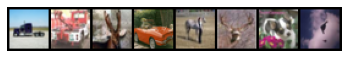

In [22]:
# View the first batch of images
plt.imshow(transposed)
plt.axis('off')
plt.show()

# Build the Model and train

In [23]:
import torch.nn as nn

In [24]:
# Define parameters of the model

input_size = 3   # number of channels in the image
hid1 = 16   # number of channels output by the first convolutional layer
hid2 = 32   # number of channels output by the second convolutional layer
out_size = len(labels)   # equal to the number of labels which is the number of categories
k_conv_size = 5 # convolutional kernel of 5 by 5

In [45]:
class Conv(nn.Module):
    
    def __init__(self):
        super(Conv, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_size, hid1, k_conv_size ),
            nn.BatchNorm2d(hid1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1, hid2, k_conv_size),
            nn.BatchNorm2d(hid2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(hid2 *  k_conv_size * k_conv_size, out_size)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        return out  # not using probabilities so work with output weights of the linear layer rather than using a softmax

In [46]:
model = Conv()

In [47]:
# Set learning rate, loss criterion and optimizer

learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [49]:
total_step = len(trainloader)
num_epochs = 5


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [2000/6250], Loss: 0.9860
Epoch [1/5], Step [4000/6250], Loss: 0.9038
Epoch [1/5], Step [6000/6250], Loss: 1.5837
Epoch [2/5], Step [2000/6250], Loss: 1.1223
Epoch [2/5], Step [4000/6250], Loss: 0.8702
Epoch [2/5], Step [6000/6250], Loss: 1.2337
Epoch [3/5], Step [2000/6250], Loss: 0.6481
Epoch [3/5], Step [4000/6250], Loss: 1.3013
Epoch [3/5], Step [6000/6250], Loss: 0.9692
Epoch [4/5], Step [2000/6250], Loss: 0.5070
Epoch [4/5], Step [4000/6250], Loss: 1.0525
Epoch [4/5], Step [6000/6250], Loss: 1.5081
Epoch [5/5], Step [2000/6250], Loss: 0.6474
Epoch [5/5], Step [4000/6250], Loss: 0.5757
Epoch [5/5], Step [6000/6250], Loss: 0.5464


# Evaluation on the test set

In [53]:
model.eval()
with torch.no_grad(): # no gradients calculated for prediction
    
    cor_pred = 0
    total_pred = 0
    for images, labels in testloader:

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        cor_pred += (predicted == labels).sum().item()

    print('Accuracy of the model on the 10000 test images: {}%'\
          .format(100 * cor_pred / total_pred))


Accuracy of the model on the 10000 test images: 67.59%
